## The *Green* Metric

We have looked at several similar yet discrete metrics relating to the city of pittsburgh *(if you haven't read the individual notebooks first, please do that before proceding)*. You have probably noticed that a common trend among our metrics is environmental support. We see this as a great method for deducing the "best" neighborhood because of how valuble the environment is. Especially in the city where pollution is at its highest and environmental areas become a well-sought-after resource. The following notebook will take the three environmental metrics and combine them into the "green" metric which will determine the true, best neighborhood in Pittsburgh.

**First lets grab all the important stuff from our individual metrics**

In [21]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas

### GreenSpaces

In [19]:
# opens the green space dataset
green_space_data = pd.read_csv("https://data.wprdc.org/dataset/cd9ae013-5b93-43d6-8793-bccf10f12c72/resource/b06fa202-ead7-491c-b8f6-2702dd35f8dd/download/opendata-pubworks-operations-green-spaces-2015.csv")
green_space_data = green_space_data.groupby("Neighborhood").sum() # finds sum of all values by neighborhood
green_space_data = green_space_data[['Total Acreage']] # narrows down the total acreage by neighborhood
#green_space_data.head(len(green_space_data)) # displays data for every neighborhood

In [41]:
# general data about every neighborhood in Pittsburgh
hood_data = pd.read_csv("https://data.wprdc.org/datastore/dump/668d7238-cfd2-492e-b397-51a6e74182ff")

hood_data = hood_data[['hood', 'acres']] # narrow down the data to just what i need

#merge the green space data and general neighborhood data for easy calculation
total_data = green_space_data.merge(hood_data, how='inner', left_on='Neighborhood', right_on='hood')

total_data['Green Percentage'] = (total_data['Total Acreage'] / total_data['acres']) * 100 # multiply by 100 for easy readability
total_data.head(len(total_data))

,Total Acreage,hood,acres,Green Percentage
0,0.10,Beechview,938.804,0.010652
1,0.10,Brookline,1338.669,0.007470
2,1.24,Central Business District,411.593,0.301268
3,1.70,Central Oakland,180.883,0.939834
4,4.15,East Liberty,373.650,1.110665
5,0.10,North Oakland,320.679,0.031184
6,1.12,Point Breeze,645.695,0.173457
7,1.40,Point Breeze North,183.781,0.761776
8,0.01,Polish Hill,163.677,0.006110
9,0.01,Regent Square,123.682,0.008085


### Smart Cans

In [33]:
SmartTCans = pd.read_csv("SmartTCansNew.csv")
# Group the csv by neighbohood and sum up all of the trashcans by neighborhood
num_cans = SmartTCans.groupby("neighborhood").sum()
num_cans = num_cans[["Number of Cans"]]
#print(num_cans.to_string())
num_cans.head()


,Number of Cans
neighborhood,
Allegheny Center,7
Allegheny West,14
Allentown,12
Arlington,3
Banksville,2


### Number of Trees

In [23]:
# Original Database. Way to many collumns that I don't need so shortened it
full_trees = pd.read_csv("https://data.wprdc.org/datastore/dump/1515a93c-73e3-4425-9b35-1cd11b2196da")
trees = full_trees[['common_name', 'height','condition','neighborhood','air_quality_benfits_total_dollar_value']].copy()
# This takes in neighborhood dataset from wprdc and shrinks it to just have a neighborhood ('hood') --> acres correlation
acres = pd.read_csv("https://data.wprdc.org/datastore/dump/668d7238-cfd2-492e-b397-51a6e74182ff")
acres = acres [['hood', 'acres']] 

# This shrinks the trees data set and then counts the occurances of each neighborhood to get trees per neighborhood
trees_per_neighborhood = full_trees [['neighborhood', 'id']] # neighborhood --> id correlation
trees_per_neighborhood = trees_per_neighborhood.rename({'id':'number_of_trees'}, axis = 1)
trees_per_neighborhood = trees_per_neighborhood.groupby('neighborhood').count()


#merges the acres data set with the trees_per_neighborhood for future caluculation
trees_per_acre_per_neighborhood = trees_per_neighborhood.merge(acres, how='inner', left_on='neighborhood',
                                                              right_on = 'hood')
trees_per_acre_per_neighborhood = trees_per_acre_per_neighborhood[['hood','number_of_trees','acres']]
trees_per_acre_per_neighborhood = trees_per_acre_per_neighborhood.rename({'hood':'neighborhood'}, axis=1)

#for some reason perry North (row 60) has 0 acres in the dataset so I manually found it on wikipedia
trees_per_acre_per_neighborhood.at[60, 'acres'] = 775.68  


# adds new colum wich divides num of trees by acres to get trees per acre (the final metric for this calculation)
trees_per_acre_per_neighborhood['trees_per_acre'] = trees_per_acre_per_neighborhood['number_of_trees'] / trees_per_acre_per_neighborhood['acres']
trees_per_acre_per_neighborhood = trees_per_acre_per_neighborhood.sort_values(by = 'trees_per_acre', ascending = False)


trees_per_acre_per_neighborhood.head(10)

/opt/tljh/user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,neighborhood,number_of_trees,acres,trees_per_acre
0,Allegheny Center,867,134.703,6.436382
33,Friendship,362,68.297,5.300379
1,Allegheny West,386,90.841,4.249183
18,Central Northside,674,166.475,4.048656
48,Manchester,707,179.566,3.937271
39,Highland Park,2941,747.691,3.933443
28,East Liberty,1366,373.650,3.655828
65,Regent Square,434,123.682,3.508999
23,Crawford-Roberts,568,166.101,3.419606
49,Marshall-Shadeland,488,148.209,3.292648


### Making the *Green* Metric

In [59]:
# merging all dataframes into one table
green_metric = trees_per_acre_per_neighborhood.merge(num_cans, how = 'left', left_on = "neighborhood", right_on = 'neighborhood')
green_metric = green_metric.merge(total_data, how = "left", left_on = "neighborhood", right_on = "hood")

#droping columns not needed
green_metric = green_metric[["neighborhood", "trees_per_acre", "Number of Cans", "Green Percentage"]]
#making any "NaN" vals 0 so we can calculate with them
green_metric["Green Percentage"] = green_metric["Green Percentage"].fillna(0)
#Applying Scalar of 10 to Green Space Percentage to give it an equal weight compared to the other metrics
#Renaming column accordingly
green_metric["Green Percentage"] = green_metric["Green Percentage"] * 10
green_metric = green_metric.rename({"Green Percentage" : "percentage_scaled_by_10"}, axis = 1)

#Averaging all three vals into a new column "green_level" which is the final metric
green_metric["green_level"] = (green_metric["trees_per_acre"]+green_metric["Number of Cans"]+green_metric["percentage_scaled_by_10"]) / 3
green_metric = green_metric.sort_values(by = "green_level", ascending = False)
green_metric.head(10)

,neighborhood,trees_per_acre,Number of Cans,percentage_scaled_by_10,green_level
6,East Liberty,3.655828,68.0,11.106651,27.587493
16,Shadyside,2.631295,77.0,0.000000,26.543765
12,Squirrel Hill South,2.953738,64.0,0.232899,22.395545
10,Bloomfield,3.181179,59.0,0.000000,20.727060
14,South Side Flats,2.814382,56.0,0.000000,19.604794
20,North Shore,2.343421,52.0,0.000000,18.114474
24,Central Oakland,2.034464,39.0,9.398340,16.810935
38,Strip District,1.243399,41.0,0.000000,14.081133
51,Carrick,0.717692,38.0,0.000000,12.905897
44,Bluff,1.054582,32.0,0.000000,11.018194


When combining all of our metrics, East Liberty comes out as the victor with Shadyside at a close second. East Liberty seems like a great choice relative to our metric because it contain high numbers of all our data sets. With a max of apprx. 6 trees/acre, 3.6 is a respectable score, 68 is one of the highest number of cans in any neighborhood (Shadyside with the actual highest) and same goes for Percent of green space. This makes East Liberty and excellent neighborhood for those who love nature and care about the envrionment. 

# **East Liberty** is The Best Neighborhood in Pittsburgh

#### graph looking at all the neighborhoods:

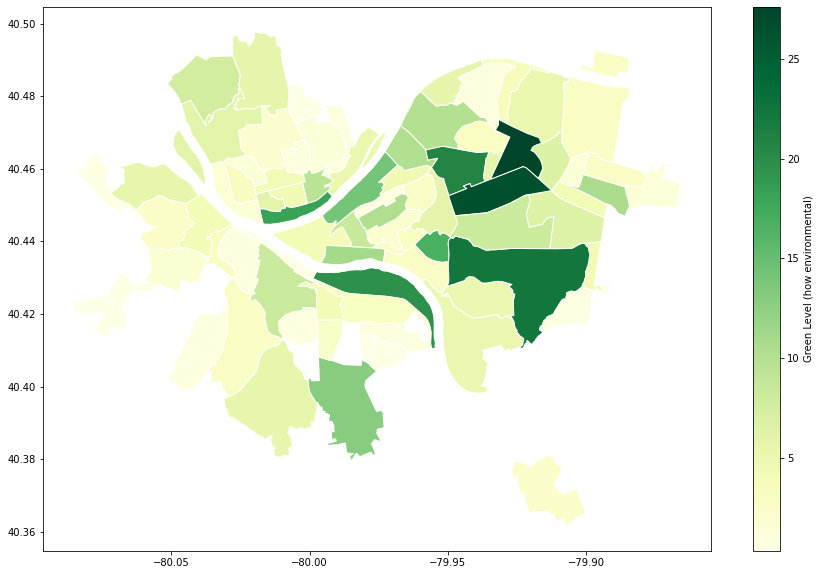

In [62]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
green_map = neighborhoods.merge(green_metric, how = 'left', left_on = "hood", right_on = "neighborhood")
green_map.plot(column = 'green_level',
               cmap = 'YlGn',
               edgecolor='white',
               legend=True,
               legend_kwds={'label' : "Green Level (how environmental)"},
               figsize=(15, 10))

# Conclusion
## 1: (Aleksandar Smith)
East Liberty won out both in terms of green spaces as well as the whole metric. This doesn't surprise me based on the numbers I got from the data, but I am a little surprised that East Liberty did so well in the other datasets. I don't really have a favorite neighborhood yet, I've only lived here for a few months and haven't really gotten around too much. If I had to pick a favorite, it would probably be Oakland, which also did pretty well in the data, specifically Central Oakland. I always appreciated how green Oakland seems as a whole, and if East Liberty is like that too, that would be pretty cool.
## 2: (Rohan Walia)
The neighborhood of East Liberty winning this comparison between our data is somewhat shocking, yet it makes a lot of sense as East Liberty is a small, quaint neighborhood that is relativley clean and environmentally consious. Therefore, by our data, it seems that East Liberty is the best neighborhood to live in. In the case of me, I believe in that as well, however in order to be fully locked in to that answer I need to spend more time in East Liberty as I've only gone there like once. Nevertheless, from what I've seen, East Liberty seems l
## 3: (Ian Y.)
I would preface this response by arguing that I haven't really been in Pittsburgh long enough to have a favorite. Despite this, I have been to East Liberty a couple times and it seemed like a very nice neighborhood. I am still partial to Oakland as that's what I'm most familiar with but I really like the metrics we choose. The envrionmental factor for a neighborhood adds a lot to a community and while something like smart trash bins may not seem important, they demonstrate how envrionmentally concious a neighborhood is. So, With a little more time in the city, this data could end up allighning with my personal preference. 
